In [1]:
import pandas as pd
import re


df_nim = pd.read_csv('nim.tsv', sep='\t')
df_b0 = pd.read_csv('b0.tsv', sep='\t')
df_b4 = pd.read_csv('b4.tsv', sep='\t')
df_b0.columns = ['file', 'mean_group1_s', 'mean_group2_s', 'time']
df_b4.columns = ['file', 'mean_group1_s', 'mean_group2_s', 'time']
df_nim['mean_group1_s'] = df_nim.apply(lambda x: 16/x.mean_group1, axis=1)
df_nim['mean_group2_s'] = df_nim.apply(lambda x: 16/x.mean_group2, axis=1)
df_nim = df_nim[['file', 'mean_group1_s', 'mean_group2_s', 'time']]

def enrich_df(df, mode_hint=None):
    df = df.copy()
    
    def extract_dataset(filename):
        m = re.match(r'^(L\d+)', filename)
        return m.group(1) if m else None
    def extract_steps(filename):
        m = re.search(r'_(10|200)\.txt$', filename)
        return int(m.group(1)) if m else None
    def detect_mode(filename):
        fname = filename.lower()
        if "nim" in fname:
            return "boltz2nim"
        if "_b0" in fname or "_b0_py" in fname:
            return "boltz2"
        
        return "boltz2b"
    df["dataset"] = df["file"].apply(extract_dataset)
    df["sampling_steps"] = df["file"].apply(extract_steps)
    
    if mode_hint is not None:
        df["mode"] = mode_hint
    else:
        df["mode"] = df["file"].apply(detect_mode)
    
    cols = ["file", "mode", "dataset", "sampling_steps"] + [c for c in df.columns if c not in ["file","mode","dataset","sampling_steps"]]
    return df[cols]

df_nim_e = enrich_df(df_nim)
df_b0_e  = enrich_df(df_b0)
df_b4_e  = enrich_df(df_b4)
df_all = pd.concat([df_nim_e, df_b0_e, df_b4_e], ignore_index=True, sort=False)
df_all = df_all.sort_values(by=["dataset", "sampling_steps", "mode"]).reset_index(drop=True)


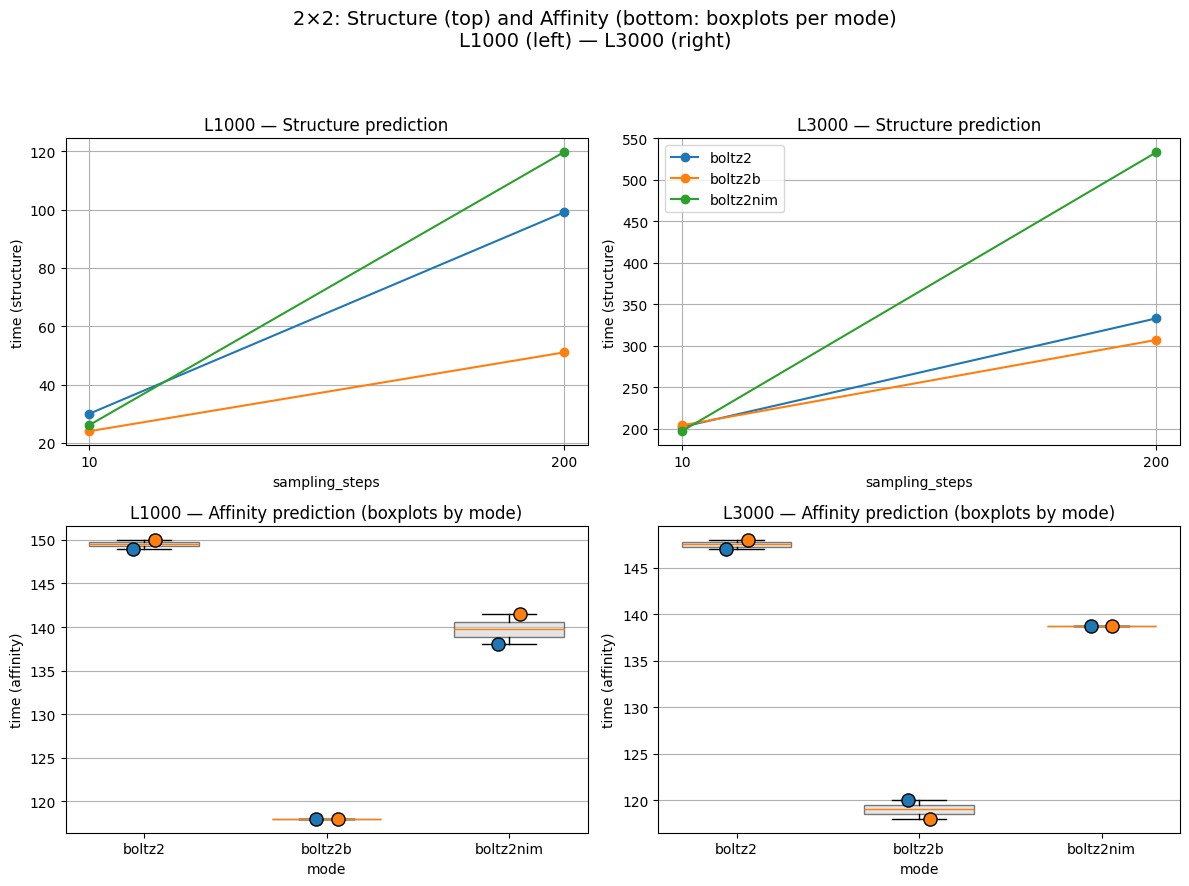

In [2]:
import matplotlib.pyplot as plt
import numpy as np


df_all['sampling_steps'] = df_all['sampling_steps'].astype(int)
df_all = df_all.sort_values(['dataset', 'sampling_steps', 'mode'])

def pick_col(df, base):
    if base in df.columns:
        return base
    alt = base + "_s"
    if alt in df.columns:
        return alt
    raise KeyError(f"Column {base} or {alt} not found in dataframe")

col_struct = pick_col(df_all, "mean_group1")  # structure metric
col_aff = pick_col(df_all, "mean_group2")     # affinity metric

datasets = ['L1000', 'L3000']
modes = sorted(df_all['mode'].unique())
sampling_steps = sorted(df_all['sampling_steps'].unique())

fig, axes = plt.subplots(2, 2, figsize=(12, 9))

# --- Top row: structure (line plots) ---
for j, ds in enumerate(datasets):
    ax = axes[0, j]
    df_ds = df_all[df_all['dataset'] == ds]
    x = sampling_steps
    for mode in modes:
        y = []
        for xx in x:
            ser = df_ds.loc[(df_ds['mode'] == mode) & (df_ds['sampling_steps'] == xx), col_struct]
            if ser.empty:
                y.append(np.nan)
            else:
                y.append(float(ser.iloc[0]))
        ax.plot(x, y, marker='o', label=mode)
    ax.set_xticks(x)
    ax.set_xlabel('sampling_steps')
    ax.set_ylabel('time (structure)')
    ax.set_title(f'{ds} — Structure prediction')
    ax.grid(True)
    if j == 1:
        ax.legend(loc='upper left')

# --- Bottom row: affinity (boxplots by mode; no mention of steps) ---
for j, ds in enumerate(datasets):
    ax = axes[1, j]
    df_ds = df_all[df_all['dataset'] == ds]

    # Prepare boxplot data: for each mode, collect affinity values across sampling_steps
    box_data = []
    box_positions = np.arange(1, len(modes) + 1)
    for mode in modes:
        vals = df_ds.loc[df_ds['mode'] == mode, col_aff].dropna().astype(float).values.tolist()
        box_data.append(vals if len(vals) > 0 else [np.nan])

    # Draw boxplots
    bp = ax.boxplot(box_data, positions=box_positions, widths=0.6, patch_artist=True, manage_ticks=False)
    for patch in bp['boxes']:
        patch.set_facecolor('#cccccc')
        patch.set_alpha(0.5)

    # X labels: modes
    ax.set_xticks(box_positions)
    ax.set_xticklabels(modes)
    ax.set_xlabel('mode')
    ax.set_ylabel('time (affinity)')
    ax.set_title(f'{ds} — Affinity prediction (boxplots by mode)')
    ax.grid(True, axis='y')

    # Overlay individual points for each sampling_step WITHOUT labels/legend mentioning steps
    jitter_width = 0.12
    for si, step in enumerate(sampling_steps):
        xs = []
        ys = []
        for i_mode, mode in enumerate(modes):
            ser = df_ds.loc[(df_ds['mode'] == mode) & (df_ds['sampling_steps'] == step), col_aff]
            if ser.empty:
                continue
            yval = float(ser.iloc[0])
            offset = -jitter_width/2 + (si / max(1, len(sampling_steps)-1)) * jitter_width if len(sampling_steps)>1 else 0
            xpos = box_positions[i_mode] + offset
            xs.append(xpos)
            ys.append(yval)
        if xs:
            # no label specified -> no legend entry about steps
            ax.scatter(xs, ys, edgecolor='k', zorder=3, s=90)

# Overall layout
plt.suptitle('2×2: Structure (top) and Affinity (bottom: boxplots per mode)\nL1000 (left) — L3000 (right)', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()
